In [90]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

# Data loading and visualization

## Loading

In [91]:
data <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

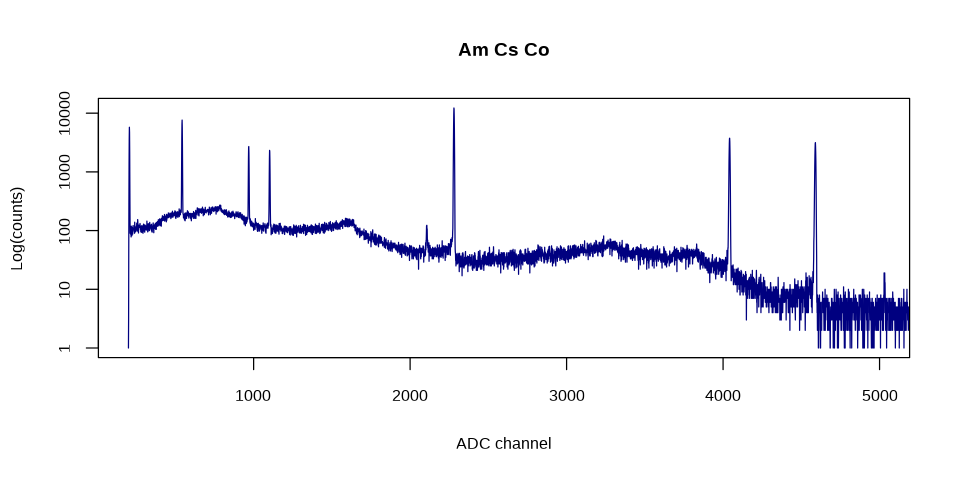

In [92]:
set_plot_dimensions(8, 4)

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [93]:
#Add tble with the energies and so on, all what we will be needing/using along the notebook
#and is external

## Peak detection and characterization

In [96]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    #fetches an array of counts with the peak at the center
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-5):(peak_idx+5)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    #fetches indices of a particular peak as it exists in the elements of data_range
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-5):(peak_idx+5))
    return(idx_c)
}

probe_peaks <- function(data, n.pts, pk_size){
    
    #split counts and channels into intervals of n.pts each
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    #find the range of values for each interval established in data_range
    minmax_range <- lapply(data_range, range_size)
    
    #filter the counts to return peaks larger than a certain size.
    peaks <- data_range[minmax_range > pk_size]
    
    #applies functions to gather counts in each of the peaks, and their indices in data_range
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    #build dataframe of channel indices
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    #convert indices gathered from data_range to channel values according to ch_range
    for(i in seq_along(colnames(centered_ch))){
        centered_ch[[colnames(centered_ch)[i]]] = ch_range[[names(lx)[i]]][lx[[i]]]
    }
    
    #build dataframe of count values
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    #bind together channel values and count values, with "Xi" corresponding to "Yi", i = 1, 2, ...
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(data, 80, 2000)

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”

In [97]:
centered_peaks 

X1,X2,X3,X4,X5,X6,X7,Y1,Y2,Y3,Y4,Y5,Y6,Y7
201,538,964,1097,2275,4037,4585,3,256,182,154,586,777,742
202,539,965,1098,2276,4038,4586,48,547,350,214,1400,1528,1278
203,540,966,1099,2277,4039,4587,328,1570,788,430,3304,2232,1893
204,541,967,1100,2278,4040,4588,1458,3904,1722,958,6290,3065,2543
205,542,968,1101,2279,4041,4589,3690,6510,2593,1712,9826,3683,3074
206,543,969,1102,2280,4042,4590,5758,7626,2703,2325,12254,3748,3153
207,544,970,1103,2281,4043,4591,4707,5680,2070,2215,11765,3275,2724
208,545,971,1104,2282,4044,4592,2114,2856,1192,1602,8721,2357,2156
209,546,972,1105,2283,4045,4593,568,1074,537,900,5231,1484,1524
210,547,973,1106,2284,4046,4594,181,386,239,414,2355,817,863


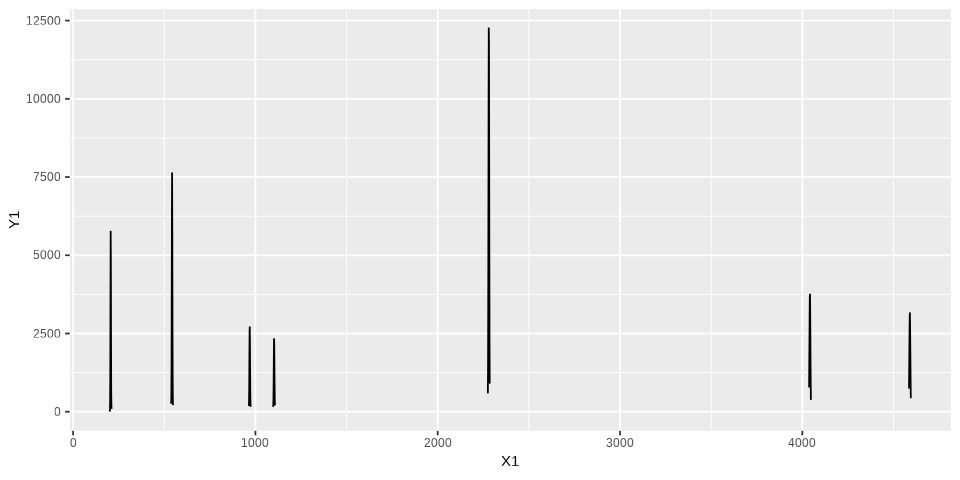

In [98]:
ggplot(data=centered_peaks)+geom_line(aes(X1,Y1))+
geom_line(aes(X2,Y2))+
geom_line(aes(X3,Y3))+
geom_line(aes(X4,Y4))+
geom_line(aes(X5,Y5))+
geom_line(aes(X6,Y6))+
geom_line(aes(X7,Y7))

# Peak processing 

In [99]:
t1 <- NULL
t1$x <- centered_peaks$X1[centered_peaks$Y1!=0]
t1$y <- centered_peaks$Y1[centered_peaks$Y1!=0]

t2 <- NULL
t2$x <- centered_peaks$X2
t2$y <- centered_peaks$Y2

t3 <- NULL
t3$x <- centered_peaks$X3
t3$y <- centered_peaks$Y3

t4 <- NULL
t4$x <- centered_peaks$X4
t4$y <- centered_peaks$Y4


peaks <-list(t1,t2,t3,t4)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  5757.999 0.141679 0.0025867      0.0025263
B    89.855 0.315092 0.0057528      0.0057531
w     1.262 0.006168 0.0001126      0.0001118
x0  206.184 0.009844 0.0001797      0.0001751

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
A  5757.71 5757.900 5757.999 5758.096 5758.275
B    89.26   89.641   89.849   90.068   90.481
w     1.25    1.258    1.262    1.266    1.274
x0  206.17  206.177  206.183  206.191  206.203



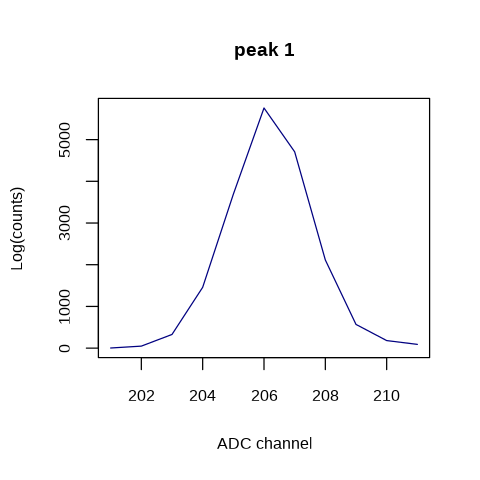

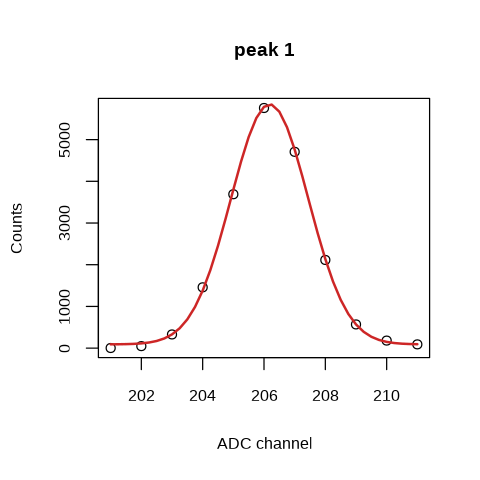

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  7625.998 0.140425 0.0025638      0.0025032
B   255.957 0.315809 0.0057659      0.0059744
w     1.488 0.006227 0.0001137      0.0001168
x0  542.816 0.009961 0.0001819      0.0001742

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  7625.729 7625.901 7625.997 7626.096 7626.274
B   255.336  255.738  255.958  256.179  256.573
w     1.476    1.484    1.488    1.493    1.501
x0  542.796  542.809  542.816  542.823  542.835



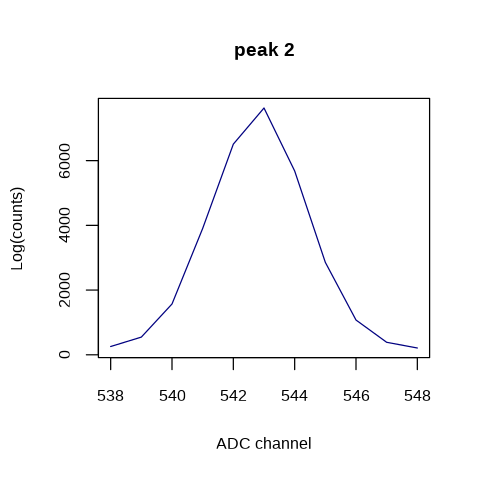

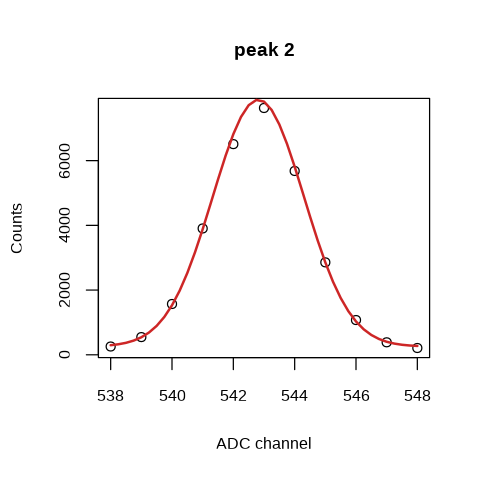

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  2702.997 0.14260 0.0026035      0.0025537
B   181.947 0.31798 0.0058056      0.0058048
w     1.589 0.01154 0.0002107      0.0002124
x0  968.727 0.01804 0.0003294      0.0003292

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  2702.714 2702.903 2702.999 2703.096 2703.282
B   181.325  181.727  181.946  182.168  182.577
w     1.567    1.581    1.589    1.596    1.613
x0  968.691  968.714  968.727  968.739  968.762



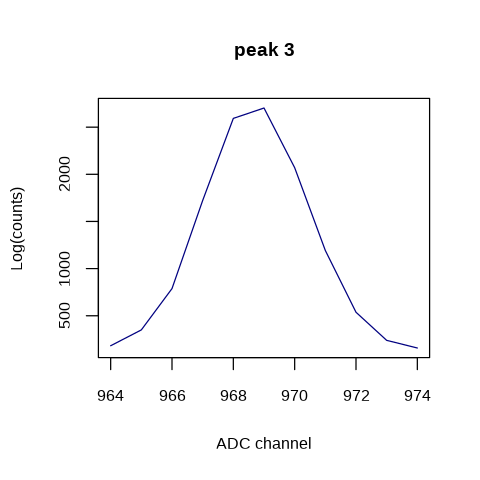

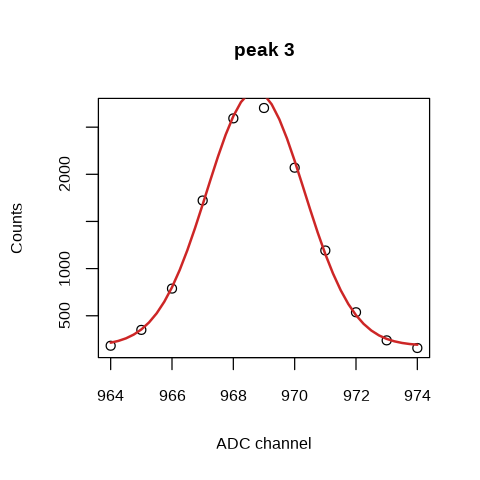

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD  Naive SE Time-series SE
A  2325.000 0.14494 0.0026463      0.0027393
B   200.945 0.31768 0.0058000      0.0057983
w     1.597 0.01276 0.0002330      0.0002235
x0 1102.445 0.01996 0.0003644      0.0003642

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  2324.715 2324.902 2325.001 2325.101 2325.283
B   200.323  200.734  200.944  201.160  201.572
w     1.572    1.589    1.598    1.606    1.622
x0 1102.407 1102.432 1102.445 1102.459 1102.484



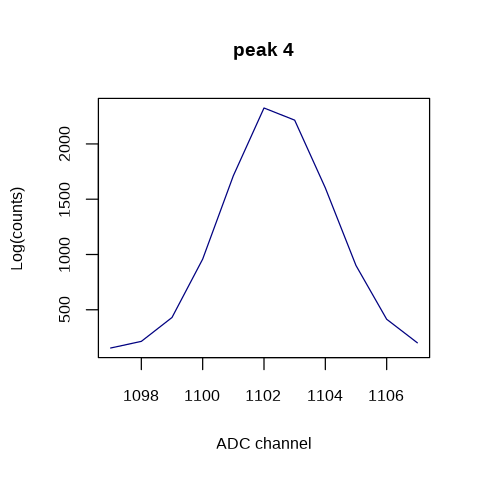

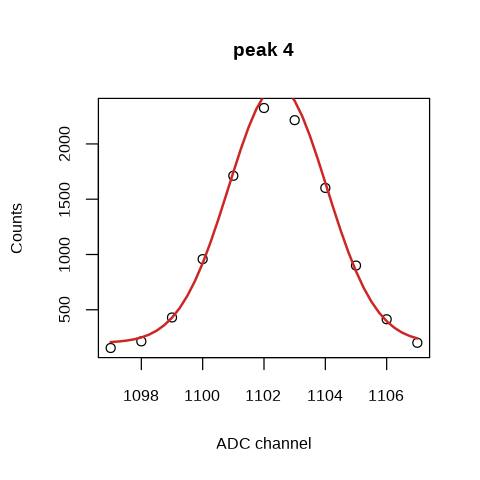

In [125]:
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()
w_mean <-c()
w_std <-c()

for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dnorm(",A.max,",",50,")
    B ~ dnorm(",B.max,",",10,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))

#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
w_mean <- c(w_mean,w)
w_std  <- c(w_std,summary(chain)$statistics[3,2])
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}

#### Americum

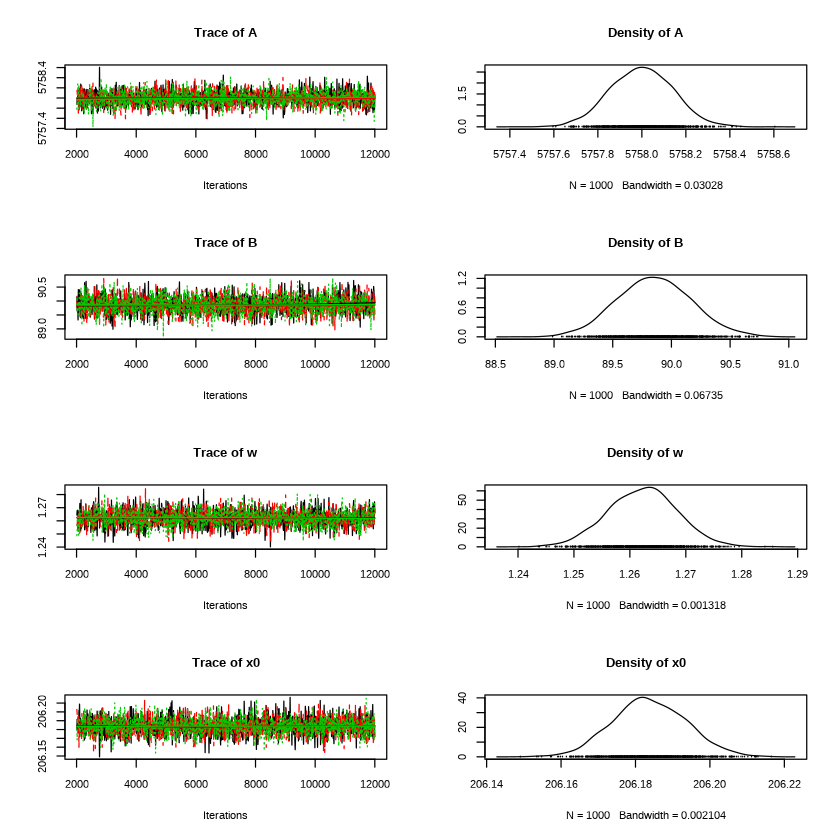

In [116]:
set_plot_dimensions(7, 7)
plot(chains[[1]])

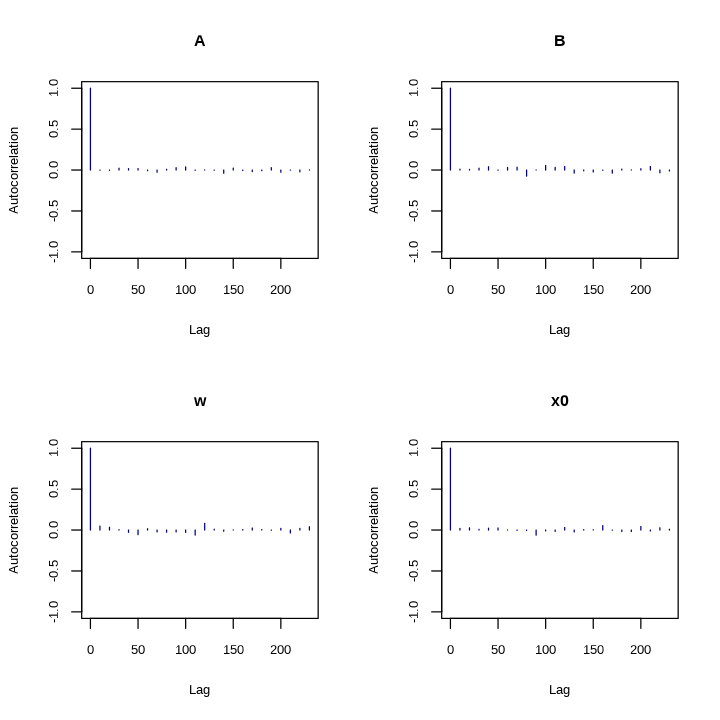

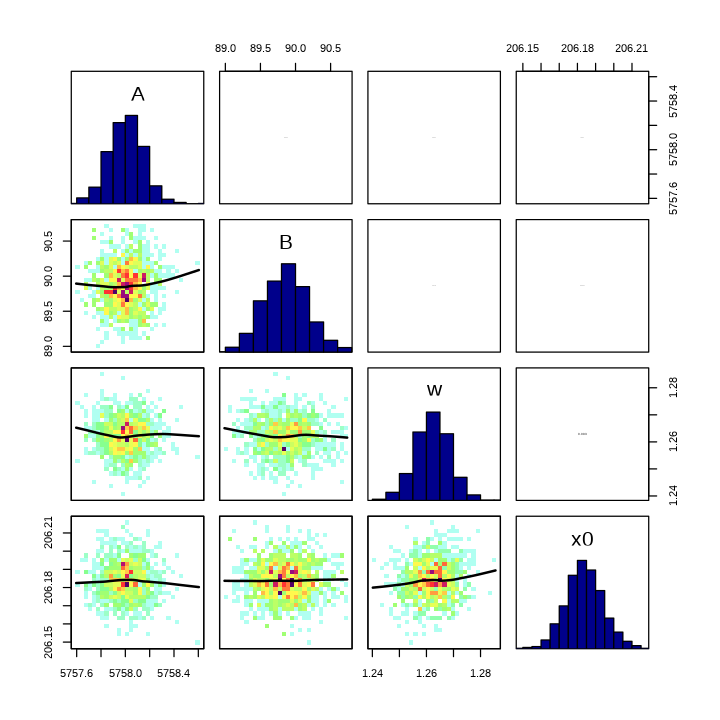

In [117]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[1]][1], col='navy')

correlationPlot((chains[[1]]))

#### Cs

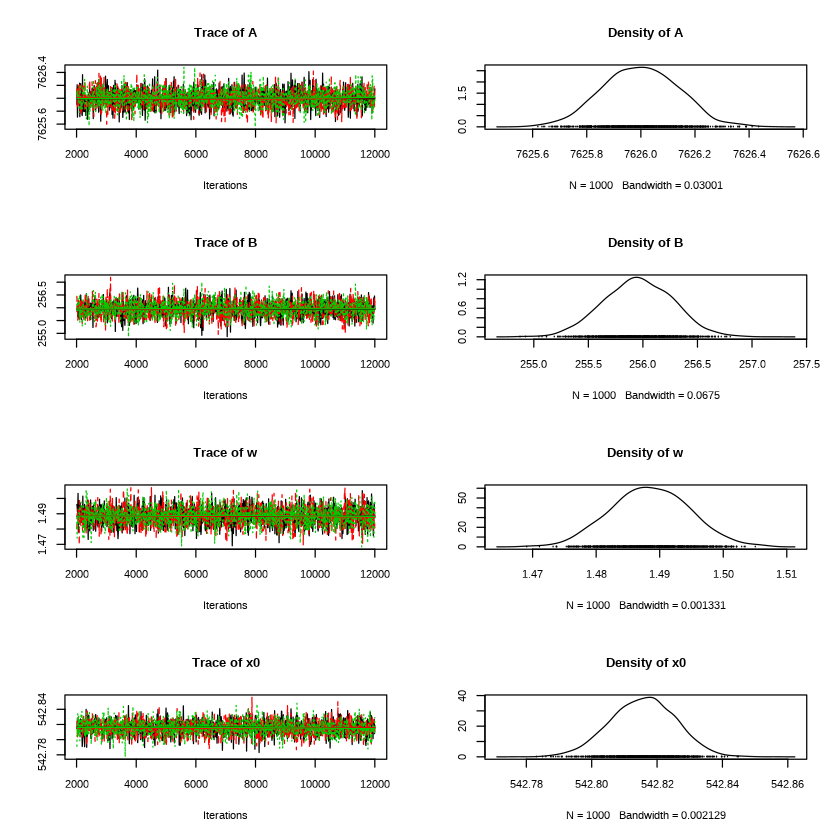

In [102]:
set_plot_dimensions(7, 7)
plot(chains[[2]])

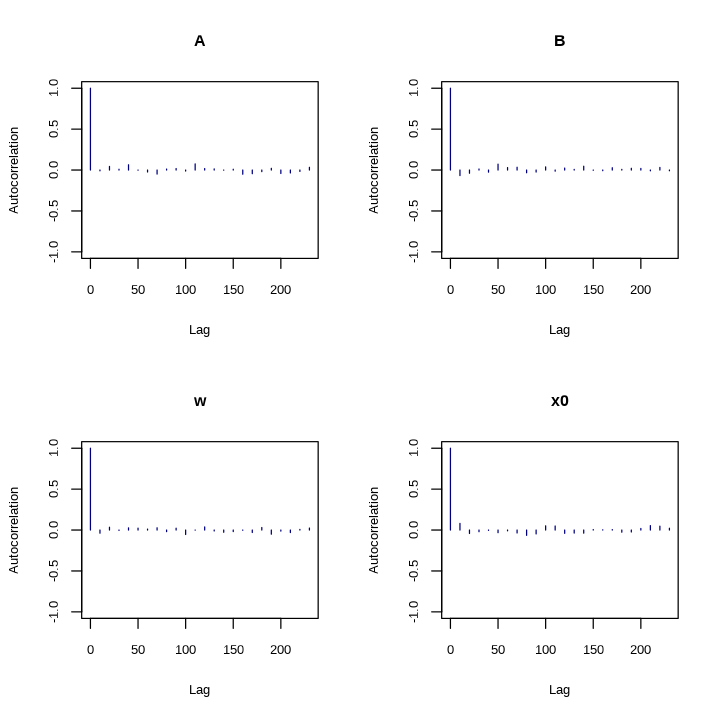

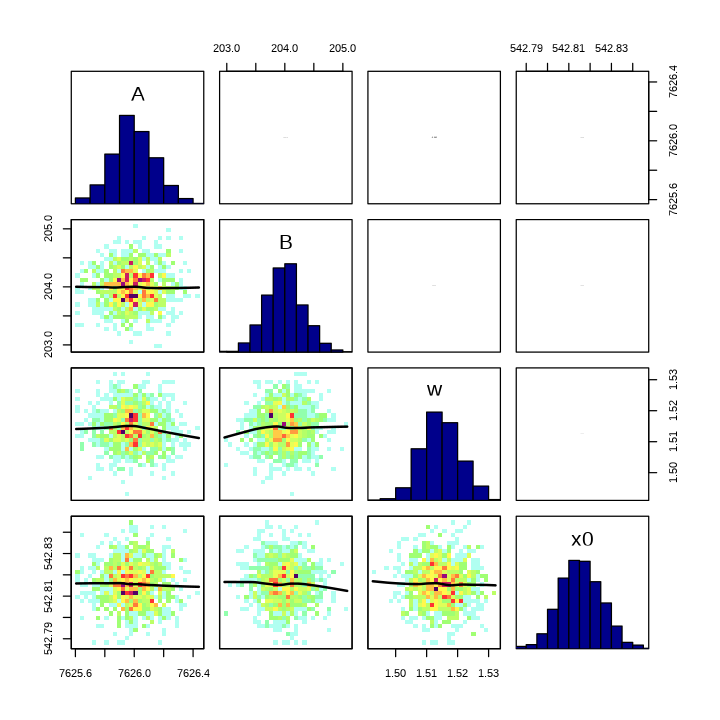

In [64]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[2]][1], col='navy')

correlationPlot((chains[[2]]))

### Co 1

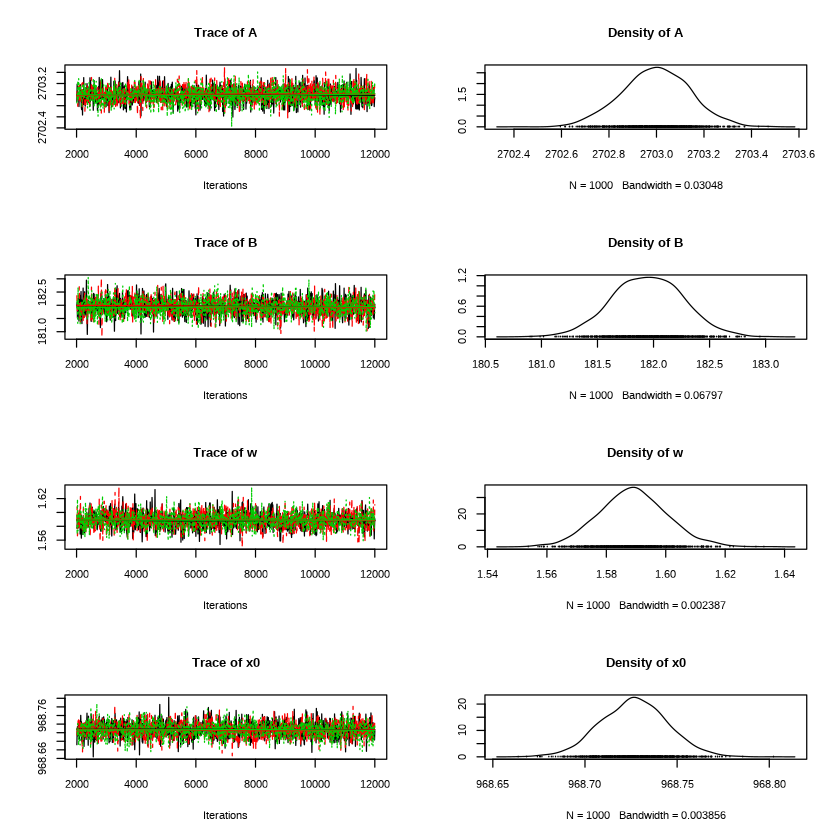

In [103]:
set_plot_dimensions(7, 7)
plot(chains[[3]])

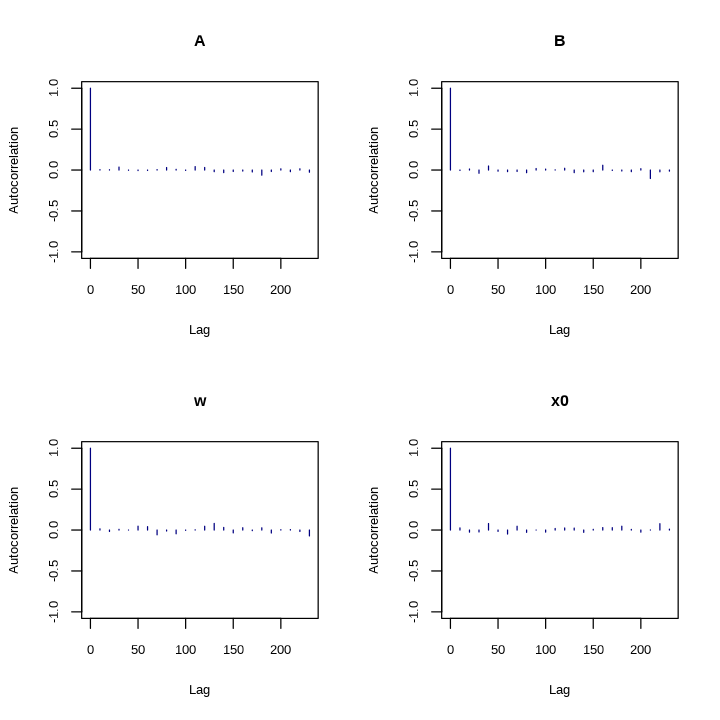

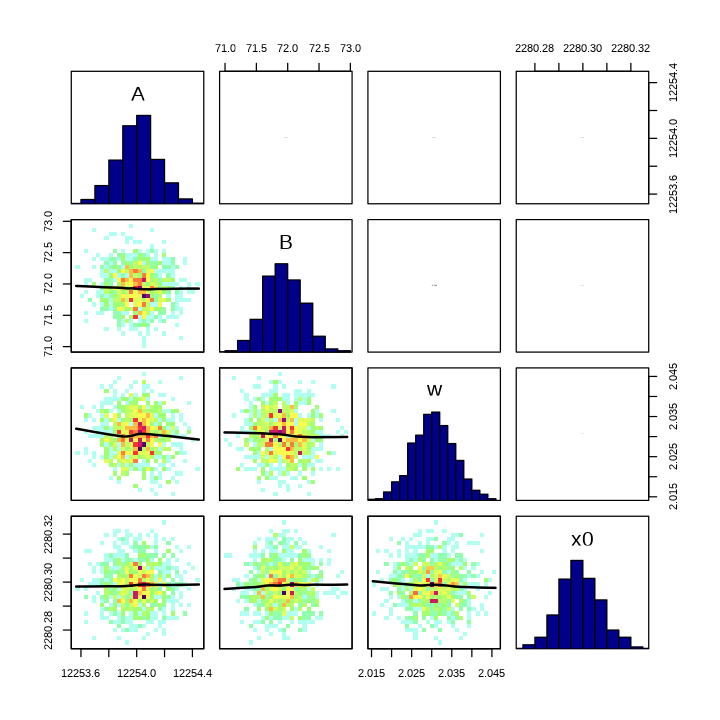

In [66]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[3]][1], col='navy')

correlationPlot((chains[[3]]))

#### Co 2


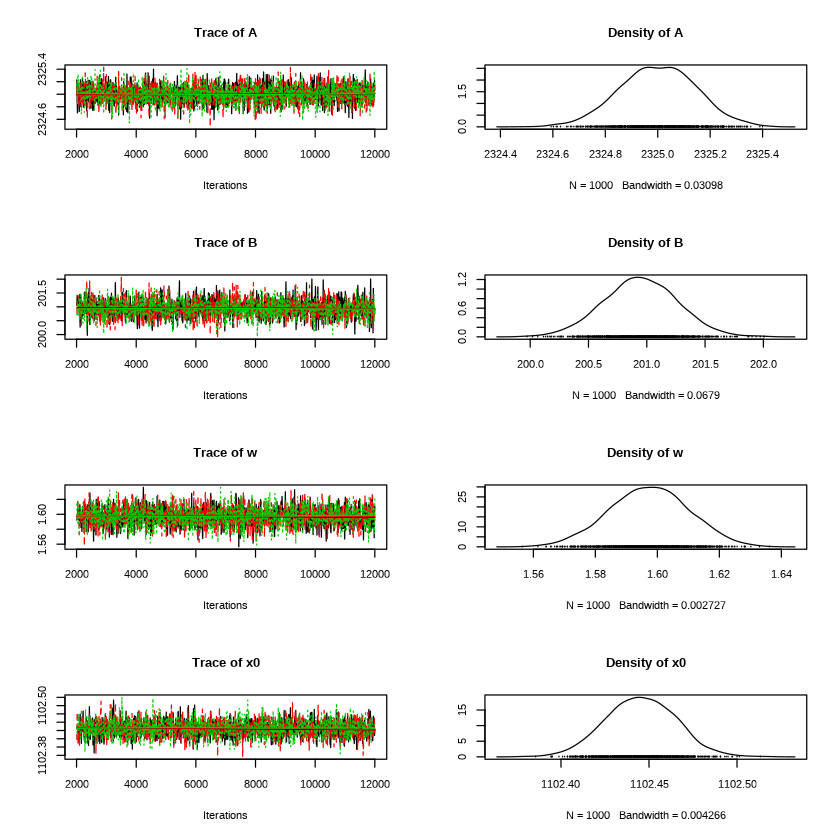

In [104]:
set_plot_dimensions(7, 7)
plot(chains[[4]])

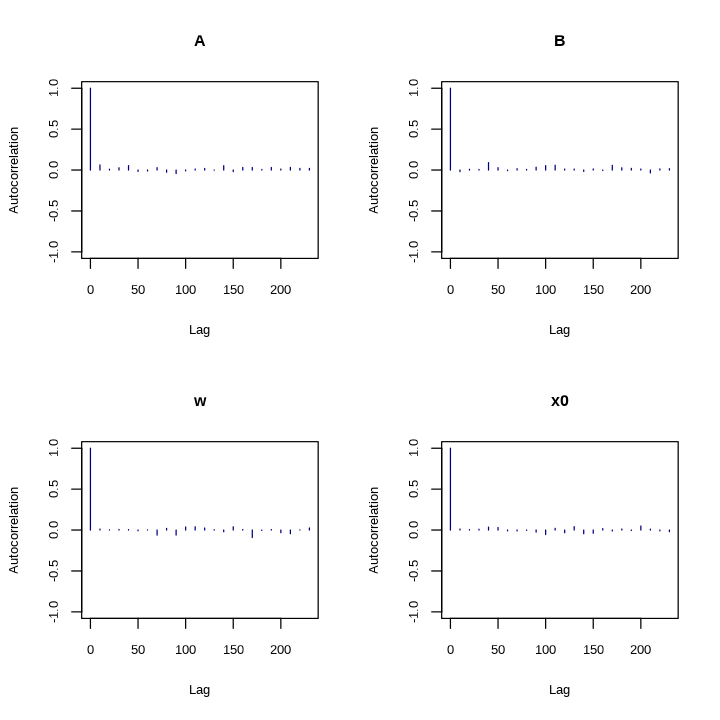

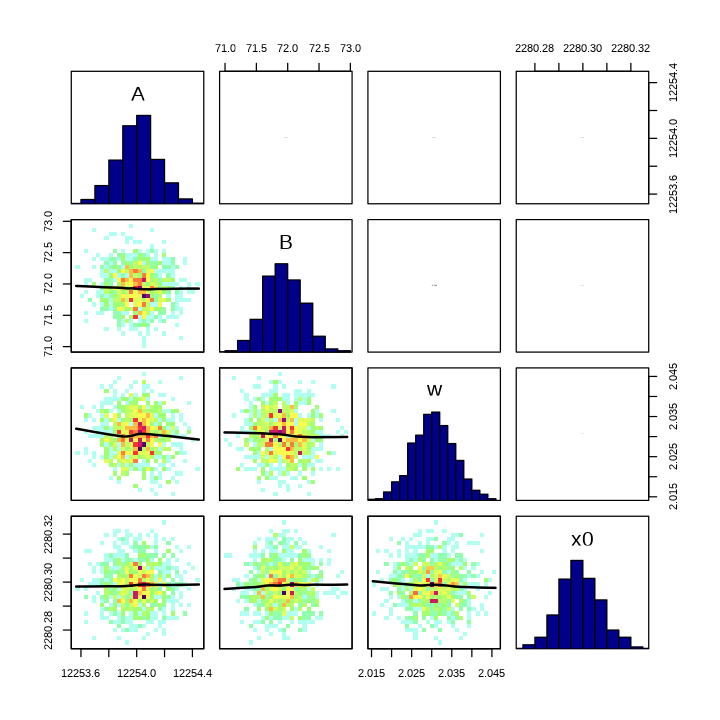

In [68]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[4]][1], col='navy')

correlationPlot((chains[[3]]))

## Energy calibration

In [118]:
peak_energy <-c(59.5409,661.657,1173.228,1332.51)


In [119]:
df <- data.frame(peak_energy,x0_mean,x0_std)
row.names(df)<-c("Am","Cs","Co_1","Co_2")

In [120]:
df

,peak_energy,x0_mean,x0_std
Am,59.5409,206.1838,0.009843893
Cs,661.6570,542.8157,0.009961485
Co_1,1173.2280,968.7266,0.018039921
Co_2,1332.5100,1102.4453,0.019957239


In [121]:
linear_fit <- lm( df$peak_energy ~ df$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
ln <- intercept + data$Ch*slope

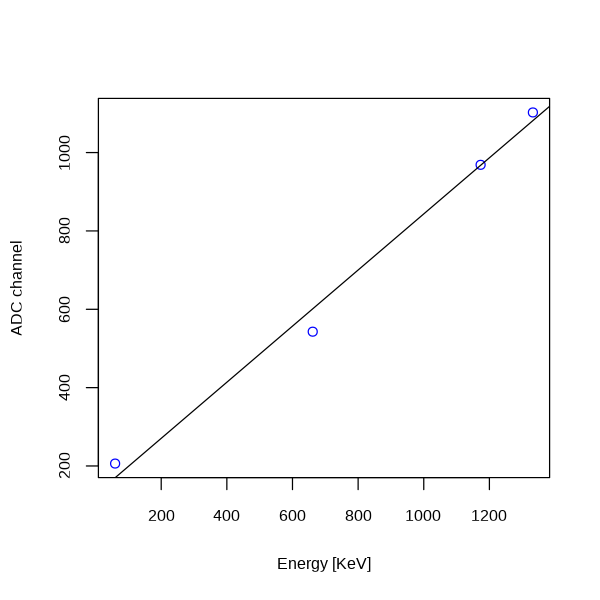

In [122]:
set_plot_dimensions(5, 5)
plot(df$peak_energy,df$x0_mean,col="blue",
    xlab="Energy [KeV]",ylab="ADC channel",
    main="")
lines(ln,data$Ch)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

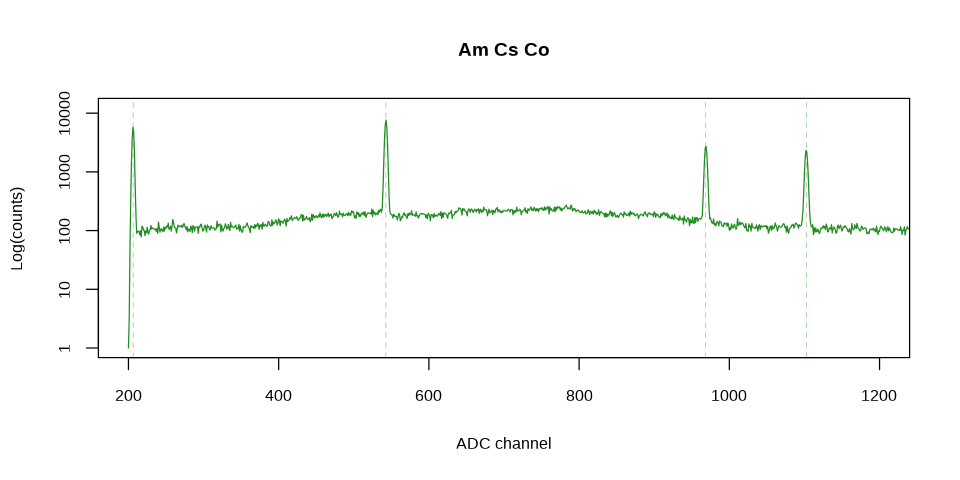

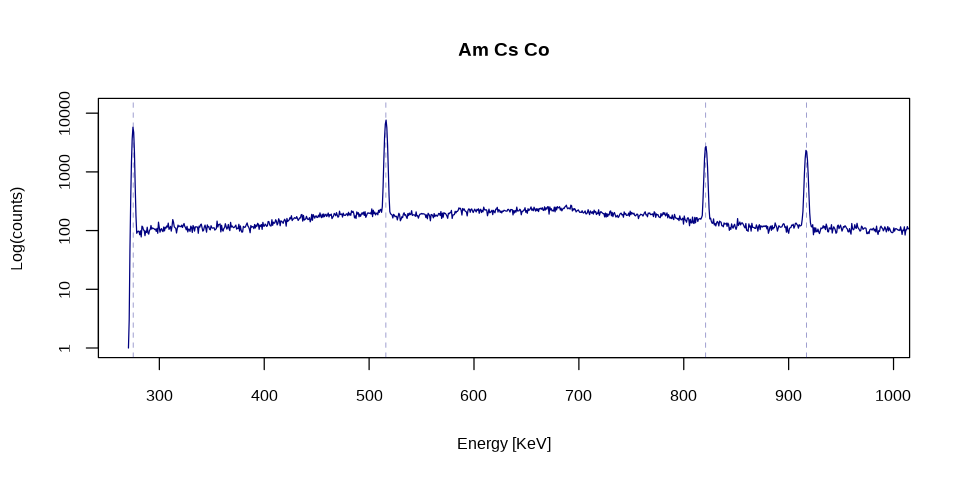

In [123]:
set_plot_dimensions(8, 4)

energy <- (data$Ch-intercept)/slope
xmin<-200;xmax<-1200
emin<-(xmin-intercept)/slope;emax<- (xmax-intercept)/slope

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=x0_mean[1],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[4],col="forestgreen",lty=2,lwd=0.3)

e0_mean <- (x0_mean-intercept)/slope

plot(energy,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
abline(v=e0_mean[1],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[2],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[3],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[4],col="navy",lty=2,lwd=0.3)

# Add the other dataset

## Resolution study